# 调度学习率

在某些时候，我们会看到如下的代码，这是代码的作者对于模型的学习率进行修改的代码。
```python
    # Reduce learning rate to half
    if args["decay_flag"] and step > (args["iteration"]//2):
        optim_dis.param_groups[0]["lr"] -= (
            args["lr"]/(args["iteration"]//2))
        optim_gen.param_groups[0]["lr"] -= (
            args["lr"]/(args["iteration"]//2))

```

在之前的Adadelta、AdaGrad、Momentum、RMSProp等算法中，我们着重关注如何更新权重向量。调整学习率与实际算法是一样重要的：
- 学习率的大小很重要，太大会导致模型发散，太小会导致模型难以收敛或者只能获得次优解
- 其次衰减速率同样是很重要的，如果学习率持续过高，我们可能最终会在最小值附近弹跳，从而无法达到最优解。简而言之，我们希望学习率随着时间步衰减，但是要比$\mathcal{O}(t^{- \frac{1}{2}})$，这样能够成为解决凸优化问题的不错选择。
- 模型初始化同样也是非常重要的。这被戏称为预热(warm up),即我们最初开始向着解决方案迈进的速度有多快。一开始的大步可能没有好处，特别是因为最初的参数集是随机的。最初的更新方向也可能是毫无意义的。
- 最后有许多优化变体可以执行周期性学习率调整

In [2]:
# import 一大堆东西
%matplotlib inline
import torch as t
import torch.nn as nn
import math
import sys
sys.path.append("../")
from pltutils import *
from torch.optim import lr_scheduler


In [3]:
def net_fn()->nn.Sequential:
    model = nn.Sequential(
        nn.Conv2d(1,6,5,1,2),nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.Conv2d(6,16,5),nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,stride=2),
        nn.Flatten(),
        nn.Linear(16*5*5,120),nn.ReLU(),
        nn.Linear(120,84),nn.ReLU(),
        nn.Linear(84,10)
    )
    return model

In [5]:
loss = nn.CrossEntropyLoss()
device = try_gpu()

batch_size = 256
train_iter , test_iter = load_data_fashion_mnist(batch_size,data_root="../dataset")

def train(net:nn.Module,train_iter,test_iter,num_epochs,loss_func,trainer,device,scheduler=None):
    net.to(device)
    animator = Animator(xlabel="epoch",xlim=[0,num_epochs],legend=["trainloss","train acc","test acc"])

    for epoch in range(num_epochs):
        metric = Accumulator(3)
        for i,(X,y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X,y = X.to(device),y.to(device)
            y_hat =net.forward(X)
            l = loss(y_hat,y)
            l.backward()
            trainer.step()
            with t.no_grad():
                metric.add(l*X.shape[0],accuracy(y_hat,y),X.shape[0])
            train_loss = metric[0]/metric[2]
            train_acc = metric[1]/ metric[2]

            if (i+1)%50 ==0:
                animator.add(epoch+i/len(train_iter),(train_loss,train_acc,None))
            test_acc = evaluate_accuracy_gpu(net,test_iter)
            animator.add(epoch+1,(None,None,test_acc))

            if scheduler:
                if scheduler.__module__ == lr_scheduler.__name__:
                    # using Pytorch In-Built scheduler
                    scheduler.step()
                else:
                    for param_group in trainer.param_groups:
                        param_group["lr"] =scheduler(epoch)
    
    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')


KeyboardInterrupt: 

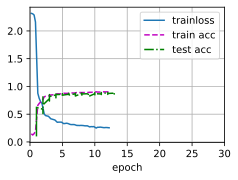

In [6]:
lr,num_epochs = 0.3,30
net = net_fn()
trainer = t.optim.SGD(net.parameters(),lr)
train(net,train_iter,test_iter,num_epochs,loss,trainer,device)

# 使用学习率调度器
可以在每个迭代轮数甚至每个小批量之后向下调整学习率，如以动态的方式来响应优化的进展情况。

In [ ]:
lr = 0.1
trainer.param_groups[0]["lr"]=lr
print(f'learning rate is now {trainer.param_groups[0]["lr"]:.2f}')


或者我们应该实现一个调度器，当调用更新次数的时候，它将返回学习率的适当值
如：
$$\eta = \eta_0 (t+1)^{- \frac{1}{2}}$$

In [7]:
class SquareRootScheduler:
    def __init__(self,lr=0.1):
        self.lr=lr
    def __call__(self,num_update):
        return self.lr * pow(num_update+1.0,-.5)

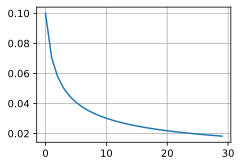

In [8]:
scheduler= SquareRootScheduler(lr=0.1)
plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

# 其它调调度策略
多项式衰减

分段常数表

余弦学习率调度（预热）

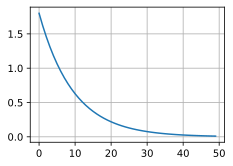

In [9]:
# 乘法衰减
class FactorScheduler:
    def __init__(self,factor=1,stop_factor_lr = 1e-7,base_lr = 0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr
    
    def __call__(self,num_update):
        self.base_lr = max(self.stop_factor_lr,self.base_lr*self.factor)
        return self.base_lr


scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
plot(torch.arange(50), [scheduler(t) for t in range(50)])


# Pytorch 内置调度器

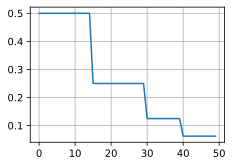

In [12]:
# 保持分段稳定的学习率，并且每隔一段时间就将学习率降低。
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[15, 30,40], gamma=0.5)


def get_lr(trainer, scheduler):
    lr = scheduler.get_last_lr()[0]
    trainer.step()
    scheduler.step()
    return lr

num_epochs=50
plot(torch.arange(num_epochs), [get_lr(trainer, scheduler)
                                    for t in range(num_epochs)])


余弦调度器
$$
\eta_t = \eta_T + \frac{\eta_0 - \eta_T}{2} (1+ cos(\pi t/T))
$$

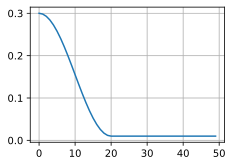

In [13]:
# 余弦调度器
class CosineScheduler:
    def __init__(self,max_update,base_lr = 0.01,final_lr = 0.,warmup_steps =0 ,warmup_begin_lr = 0):
        self.base_lr_orig = base_lr
        self.max_update=max_update
        self.final_lr=final_lr
        self.warmup_steps=warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps
    
    def get_warmup_lr(self,epoch):
        increase = (self.base_lr_orig-self.warmup_begin_lr)*float(epoch)/float(self.warmup_steps)
        return self.warmup_begin_lr+ increase
    
    def __call__(self,epoch):
        if epoch<self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch<=self.max_update:
            self.base_lr = self.final_lr+(self.base_lr_orig-self.final_lr)*(1+ math.cos(math.pi*(epoch-self.warmup_steps)/self.max_steps))/2
        return self.base_lr

scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

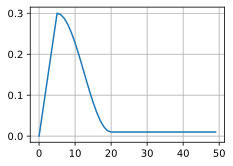

In [14]:
# 有预热的情况
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

- 在训练期间逐步降低学习率可以提高准确性，并且能够有效地减少模型的过拟合
- 每当进展趋于稳定的时候就降低学习率，是很有效的。这个可以确保我们可以有效地收敛到一个适当的解，也只有这样才能够通过降低学习率来减少参数的固有方差
- 余弦调度器在cv中很受欢迎
- 优化之前使用预热warmup能够有效防止发散
- 优化在深度学习中有多种用途，对于同样地训练误差而言，选择不同的优化算法和学习率调度，能够减少训练时间，还能够导致在测试集上不同的泛化和过拟合量